# SMFM Deforest

The DEnse FOREst Time Series (deforest) tool is a method for detecting changes in forest cover in a time series of Earth observation data. As input it takes a time series of forest probability measurements, producing a map of deforestation and an 'early warning' map of unconfirmed changes. The method is based on the 'Baysian time series' approach of [Reiche et al. (2018)](https://doi.org/10.1016/j.rse.2017.10.034). 

The tool was designed as part of the Satellite Montioring for Forest Management (SMFM) project. The SMFM project (2017 - 2020) aimed to address global challenges relating to the montioring of tropical dry forest ecosystems, and was conducted in partnership with teams in Mozambique, Namibia and Zambia. For more informaton, see https://www.smfm-project.com/.

Full documentation is hosted at http://deforest.rtfd.io/.


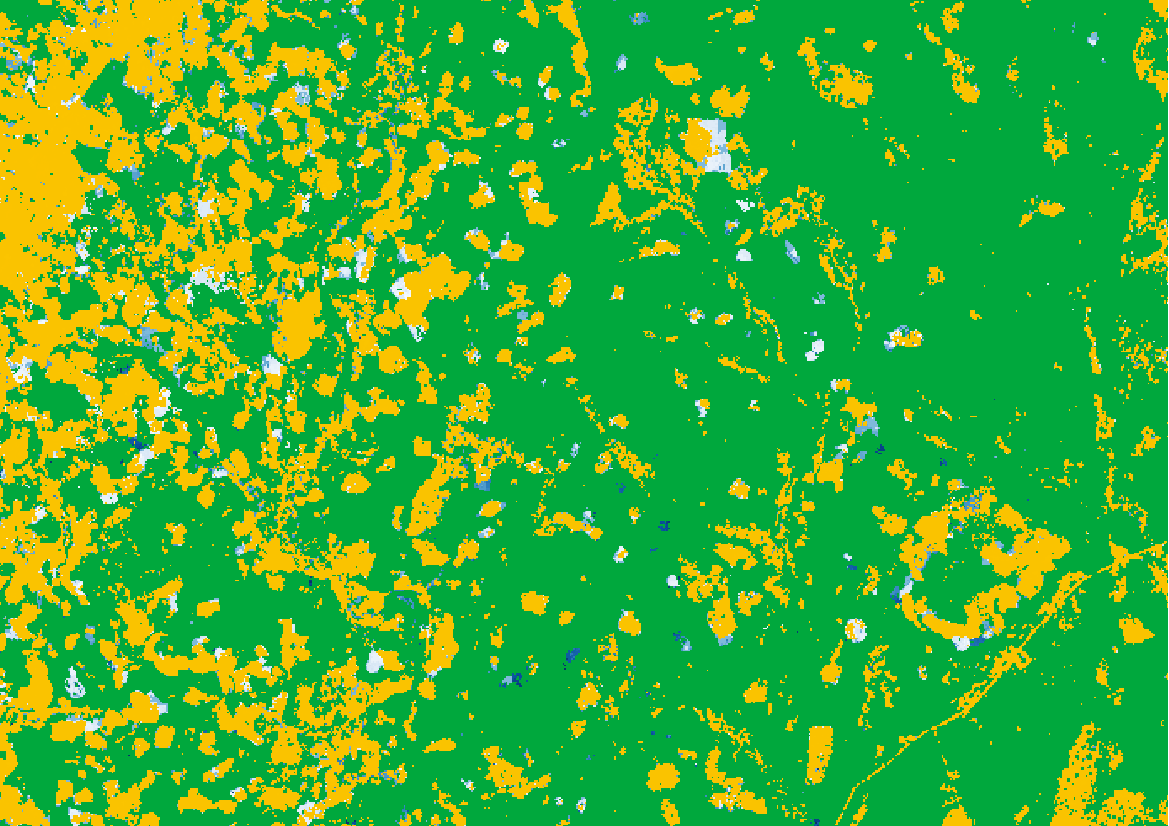

*Example output from SMFM deforest from an area of central Mozambique, showing stable forest in green, stable non-forest in orange, and deforestation in blue (darker = more recent).*

## Data preparation

SMFM Deforest is in the process of being adapted for use on SEPAL. The forest probability time series will be derived from existing methods to produce a satellite sime series implemented on SEPAL. The current processing chain is:

1. Create an optical mosaic with the satellite of your choice
1. Save the mosaic as a recipe
1. Open a new classification and point to the optical mosaic recipe as the image to classify
1. Derive training data (directly in SEPAL or upload from another source)
1. Apply a classifier
1. Select the %forest output
1. Save the classification as a recipe
1. Open a new time-series
1. Select the AOI and dates
1. In the 'SRC' box you will have the chance to select the satellite and the classification to apply
1. Then you can download the time series to your SEPAL workspace 

## Setup

In this section the SMFM deforest software will be downloaded and installed.

In [ ]:
# Clone the code repository
#!git clone https://github.com/smfm-project/deforest

# Install
!pip install deforest

# Display tool documentation
!python3 ~/deforest/sepal/change.py --help

## Process the time series

For the purposes of this example, we'll use sample data bundled with the code repository. To use an alternative dataset change the directory to point to an alternative SEPAL time series.

In [ ]:
# Run for the sample time series
# -n: Output to files preceded by 'sampleOutput'
# -d: Only include the wet season (Dec - April)
# -t: Set a threshold of 0.999 to flag deforestation
# -s: Scale inputs by a factor of 6000. In a full-scale run this should be set to 10000, here it's used to correct an inadequate classifcation
# -v: Make the script chatty
!python3 ~/deforest/sepal/change.py ~/deforest/sepal/example_data/Time_series_2021-03-24_10-53-03/0/ -n sampleOutput -d 12-01 04-30 -t 0.999 -s 6000 -v

# List output data once processing is complete.
!ls sampleOutput*

## Data visualisation

This section loads the outputs from the deforestation processing chain, and visualises output maps.

The image ``sampleOutput_confirmed.tif`` shows the year of changes that have been detected in the time series (in this case the Landsat 8 period period 2013-2021). Locations of remaining forest are numbered 0. Note that the changes in the first year or two will be mostly spurious, as the landscape is initially considered entirely forested. It is recommended that the user either discards the first 2-3 years of changes, or uses a high-quality forest baseline map to mask out locations that weren’t forest at the start of the time series.

The change map is visualised below, with deforestation events coloured in blue (darker colours = more recent changes).

In [ ]:
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal

# Load data, removing a small border region for neat-ness
confirmed = gdal.Open('sampleOutput_confirmed.tif', 0).ReadAsArray()[25:-25,25:-25]

# Extract rasters for forest, non-forest, and deforestation
stable_forest = confirmed == 0
stable_nonforest = (confirmed <= 2015) & (stable_forest == False)
deforestation_yr = confirmed * ((stable_forest == False) & (stable_nonforest == False))

# Colour maps for output
cmap_forest = matplotlib.colors.LinearSegmentedColormap.from_list("", ['white', '#38a838'])
cmap_nonforest = matplotlib.colors.LinearSegmentedColormap.from_list("", ['white', '#f5c200'])

# Visualise
fig, ax = plt.subplots(figsize=(8,6), dpi=300)
ax.imshow(np.ma.array(stable_forest, mask = stable_forest == False), interpolation='nearest', cmap=cmap_forest, vmin=0,vmax=1)
ax.imshow(np.ma.array(stable_nonforest, mask = stable_nonforest == False), interpolation='nearest', cmap=cmap_nonforest, vmin=0,vmax=1)
def_yr_im = ax.imshow(np.ma.array(deforestation_yr, mask = deforestation_yr == 0), interpolation='nearest', cmap='Blues', vmin=2015,vmax=2020)
plt.colorbar(def_yr_im, fraction=0.02, pad=0.04)
plt.show()

The image ``sampleOutput_warning.tif`` shows the combined probability of non-forest existing at the end of the time series in locations that have not yet been flagged as deforested. This can be used to provide information on locations that have not yet reached the threshold for confirmed changes, but are looking likely to possible. A simple probability threshold can be applied to supply early warnings.

In this example, early warnings are displayed in reds, with darker reds showing greater confidence in deforestation having ocurred.

In [ ]:
# Load data, removing a small border region for neat-ness
warning = gdal.Open('sampleOutput_warning.tif', 0).ReadAsArray()[25:-25,25:-25]

# Visualise
fig, ax = plt.subplots(figsize=(8,6), dpi=300)
ax.imshow(np.ma.array(stable_forest, mask = stable_forest == False), interpolation='nearest', cmap=cmap_forest, vmin=0,vmax=1)
ax.imshow(np.ma.array(stable_nonforest, mask = stable_nonforest == False), interpolation='nearest', cmap=cmap_nonforest, vmin=0,vmax=1)
def_yr_im = ax.imshow(np.ma.array(deforestation_yr, mask = deforestation_yr == 0), interpolation='nearest', cmap='Blues', vmin=2015,vmax=2020)
warn_im = ax.imshow(np.ma.array(warning, mask = warning <= 0.99), interpolation='nearest', cmap='Reds', vmin=0.99,vmax=1)
plt.colorbar(warn_im, fraction=0.02, pad=0.04)
plt.show()
